# 1. VHM Dataset

In [114]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [115]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('../Datasets/1 - VHM Historical Data.csv')
df = df.iloc[::-1].reset_index(drop=True)  # Reverse the dataframe
df['Date'] = pd.to_datetime(df['Date'])
df1 = df['Price'].str.replace(',', '').astype(float)

In [116]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [117]:
df1

array([[0.5961768 ],
       [0.62907782],
       [0.5961768 ],
       ...,
       [0.01989179],
       [0.01094048],
       [0.00795672]])

## Ratio 9:1

In [118]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [119]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [120]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [121]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [122]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [123]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0416 - val_loss: 0.0013
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0043 - val_loss: 7.9240e-04
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0018 - val_loss: 7.8971e-04
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0017 - val_loss: 4.9776e-04
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0015 - val_loss: 4.1406e-04
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013 - val_loss: 3.8646e-04
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013 - val_loss: 3.5603e-04
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013 - val_loss: 3.5356e-04
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013 - val_loss: 3.0275e-04
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0012 - val_loss: 4.3101e-04
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0011 - val_loss: 3.2297e-04
Epoch 12/100


In [124]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [125]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
ytest = scaler.inverse_transform(ytest.reshape(-1, 1))

In [126]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred) * 100
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 671.0987431540319
Testing MAPE: 1.2040894124575945
Testing MAE: 491.230720766129


In [127]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

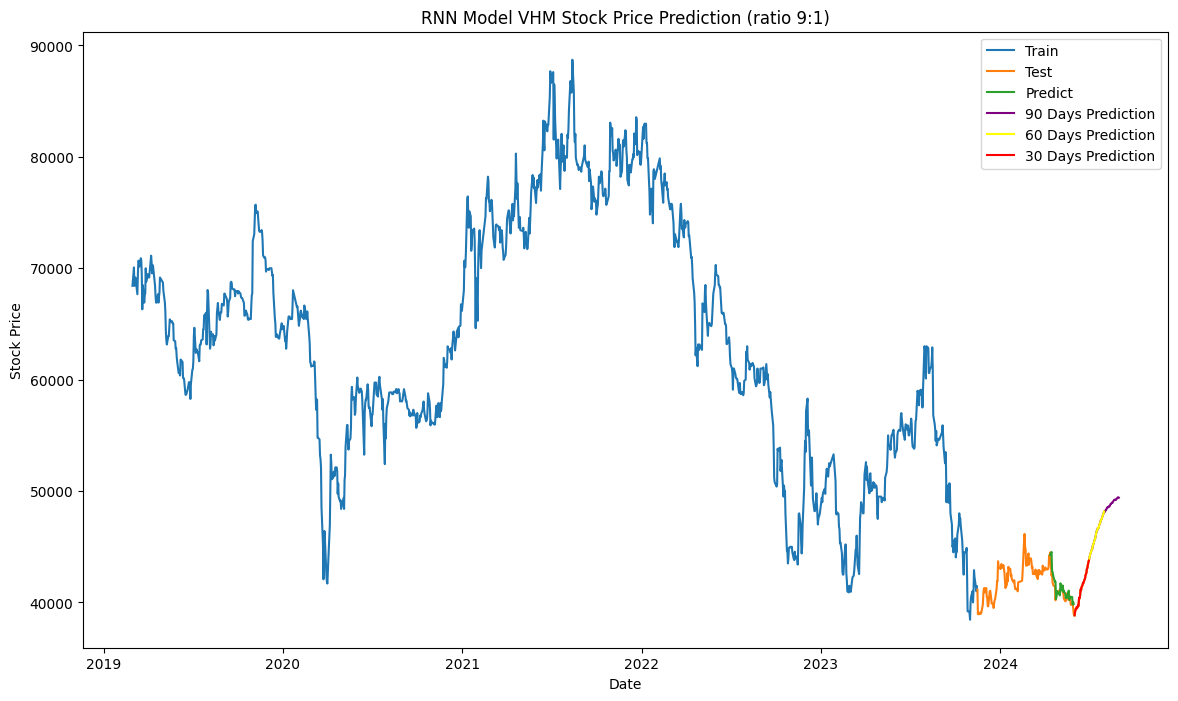

In [128]:
# 14. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=61)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=91)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('RNN Model VHM Stock Price Prediction (ratio 9:1)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()


## Ratio 8:2

In [129]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [130]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [131]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [132]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [133]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [134]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.3709 - val_loss: 0.0683
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0132 - val_loss: 0.0151
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0058 - val_loss: 0.0072
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0033 - val_loss: 0.0043
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0026 - val_loss: 0.0038
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0019 - val_loss: 0.0030
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

In [135]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [136]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
ytest = scaler.inverse_transform(ytest.reshape(-1, 1))

In [137]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred) * 100
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 855.1163472088316
Testing MAPE: 1.4685643026969433
Testing MAE: 617.9320746527778


In [138]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

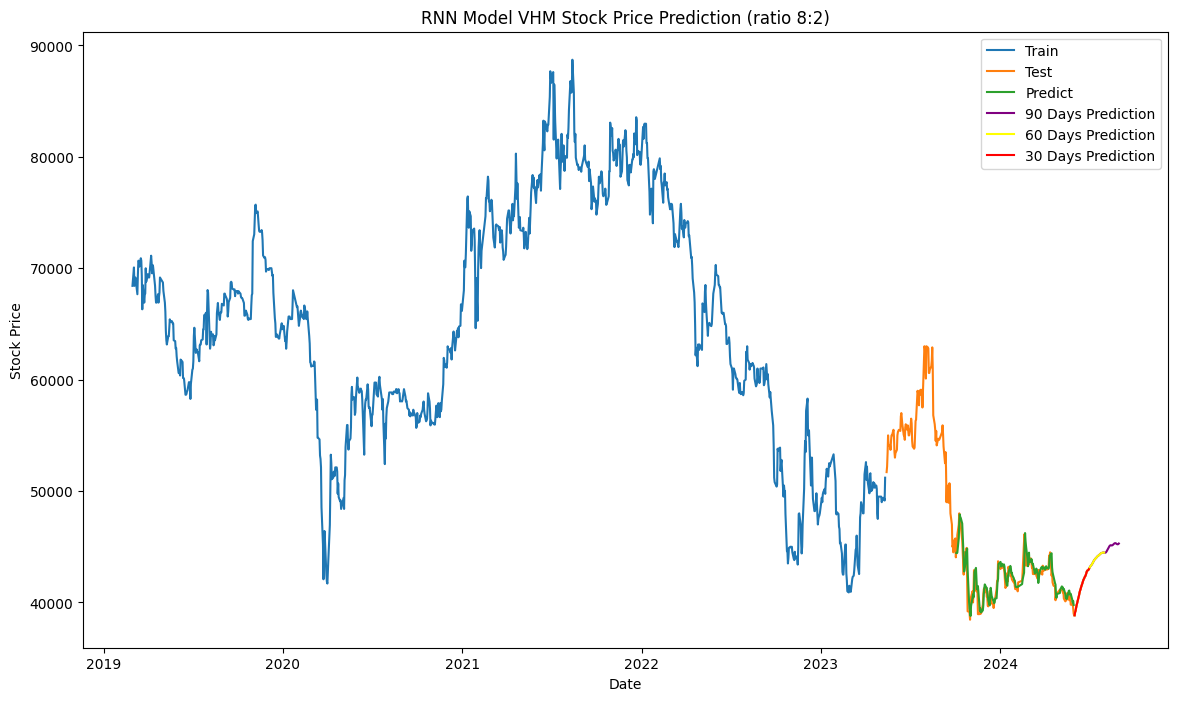

In [139]:
# 14. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=61)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=91)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('RNN Model VHM Stock Price Prediction (ratio 8:2)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()


## Ratio 7:3

In [140]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [141]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [142]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [143]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [144]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [145]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.5533 - val_loss: 0.0680
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0087 - val_loss: 0.0139
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0039 - val_loss: 0.0025
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0024 - val_loss: 0.0081
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0021 - val_loss: 0.0051
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0020 - val_loss: 0.0042
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0019 - val_loss: 0.0031
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0019 - val_loss: 0.0034
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0018 - val_loss: 0.0033
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0017 - val_loss: 0.0024
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

In [146]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [147]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
ytest = scaler.inverse_transform(ytest.reshape(-1, 1))

In [148]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred) * 100
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 1407.932775221285
Testing MAPE: 2.4134336177814673
Testing MAE: 1115.66268931314


In [149]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))


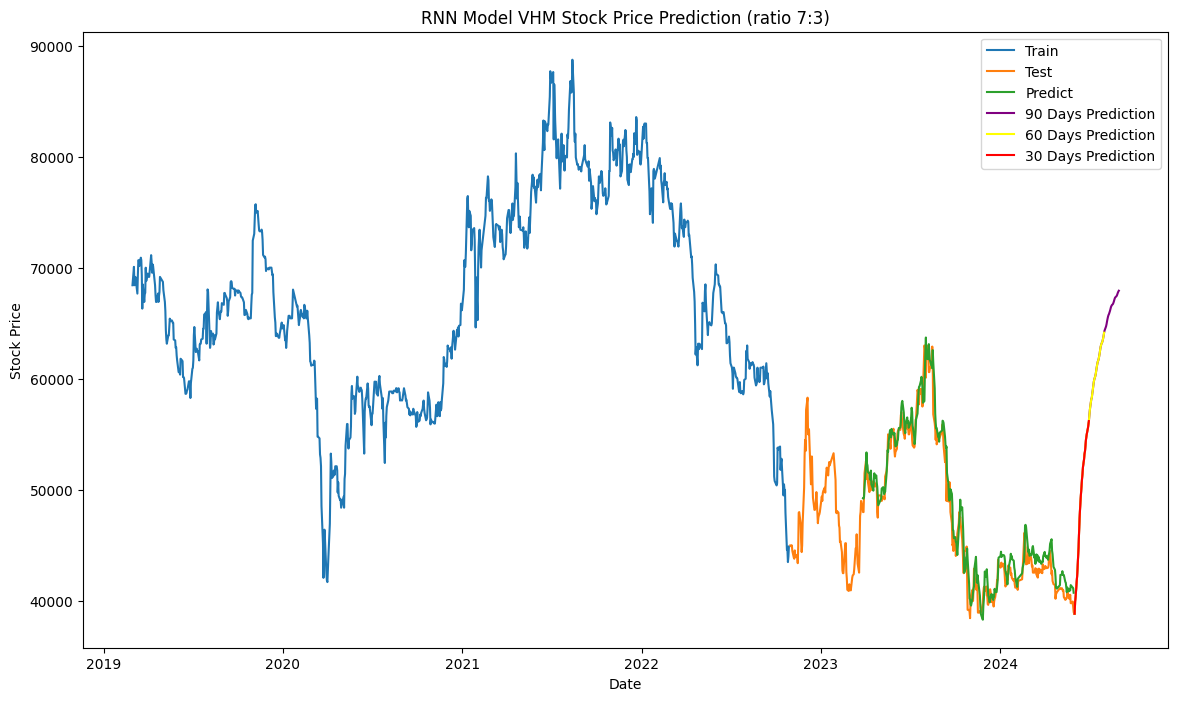

In [150]:
# 14. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=61)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=91)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('RNN Model VHM Stock Price Prediction (ratio 7:3)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()


# 2. NVL Dataset

In [151]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [152]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('../Datasets/2 - NVL Historical Data.csv')
df = df.iloc[::-1].reset_index(drop=True)  # Reverse the dataframe
df['Date'] = pd.to_datetime(df['Date'])
df1 = df['Price'].str.replace(',', '').astype(float)

In [153]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [154]:
df1

array([[0.27623119],
       [0.27826489],
       [0.27352769],
       ...,
       [0.04749379],
       [0.04749379],
       [0.05114716]])

## Ratio 9:1

In [155]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [156]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [157]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [158]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [159]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [160]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0142 - val_loss: 4.6649e-04
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0012 - val_loss: 3.1790e-04
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.9615e-04 - val_loss: 1.6528e-04
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.9694e-04 - val_loss: 1.4142e-04
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.6710e-04 - val_loss: 1.3216e-04
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.0580e-04 - val_loss: 1.0209e-04
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.7155e-04 - val_loss: 9.1448e-05
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.3361e-04 - val_loss: 9.1772e-05
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.8045e-04 - val_loss: 8.8624e-05
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.3095e-04 - val_loss: 8.2159e-05
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.2933

In [161]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [162]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
ytest = scaler.inverse_transform(ytest.reshape(-1, 1))

In [163]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred) * 100
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 467.8075116355286
Testing MAPE: 2.159087495199624
Testing MAE: 320.2515751008061


In [164]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))


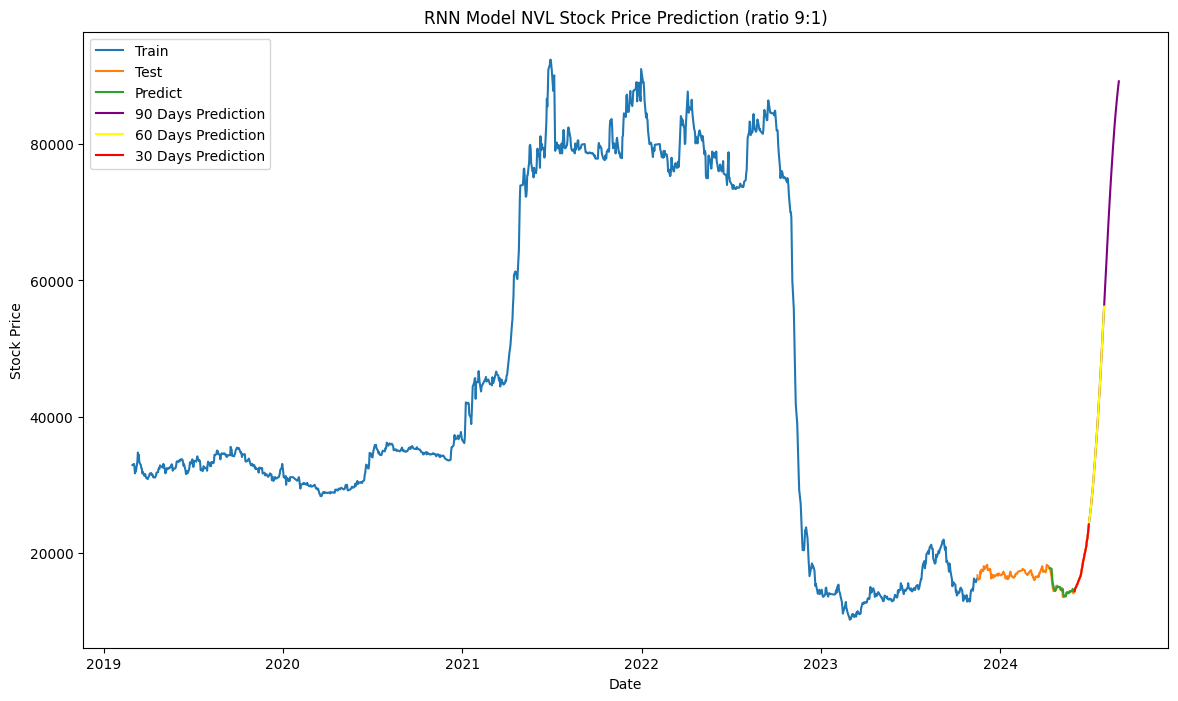

In [165]:
# 14. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=61)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=91)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('RNN Model NVL Stock Price Prediction (ratio 9:1)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

## Ratio 8:2

In [166]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [167]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [168]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [169]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [170]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [171]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.6969 - val_loss: 0.0389
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0196 - val_loss: 0.0025
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0054 - val_loss: 0.0015
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0019 - val_loss: 6.1978e-04
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0021 - val_loss: 3.9760e-04
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0022 - val_loss: 5.4809e-04
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0019 - val_loss: 3.0183e-04
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0017 - val_loss: 3.7382e-04
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0018 - val_loss: 4.4011e-04
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0017 - val_loss: 5.6394e-04
Epoch 12/100
15/15 ━━━━━

In [172]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [173]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
ytest = scaler.inverse_transform(ytest.reshape(-1, 1))

In [174]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred) * 100
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 761.6275216012872
Testing MAPE: 3.7462554251789104
Testing MAE: 594.5092411747685


In [175]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

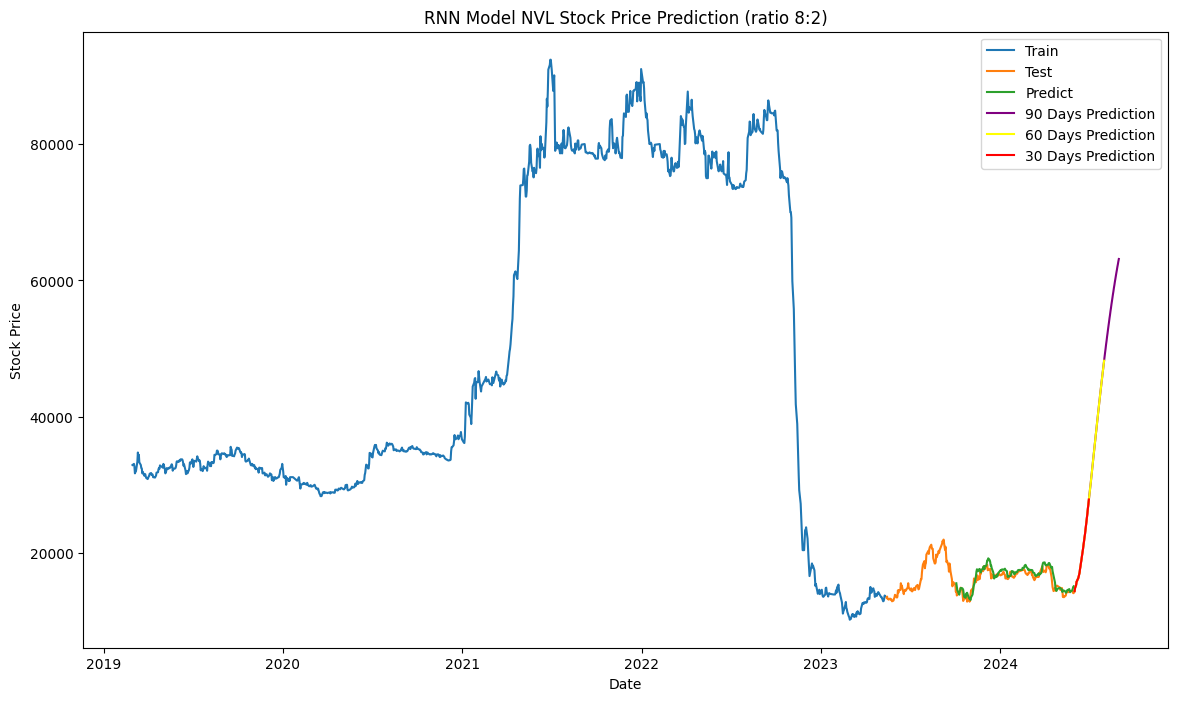

In [176]:
# 14. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=61)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=91)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('RNN Model NVL Stock Price Prediction (ratio 8:2)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

## Ratio 7:3

In [177]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [178]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [179]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [180]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [181]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [182]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0907 - val_loss: 0.0011
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0024 - val_loss: 6.3048e-04
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0014 - val_loss: 5.9057e-04
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.6153e-04 - val_loss: 7.7610e-04
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.3459e-04 - val_loss: 8.0010e-04
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.2408e-04 - val_loss: 6.0519e-04
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.4791e-04 - val_loss: 6.5170e-04
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.8834e-04 - val_loss: 5.7160e-04
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.7348e-04 - val_loss: 5.8002e-04
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.5664e-04 - val_loss: 5.4417e-04
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.3583e-04 - v

In [183]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [184]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
ytest = scaler.inverse_transform(ytest.reshape(-1, 1))

In [185]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred) * 100
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 867.0825907460317
Testing MAPE: 4.381291794503865
Testing MAE: 694.6298861454778


In [186]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

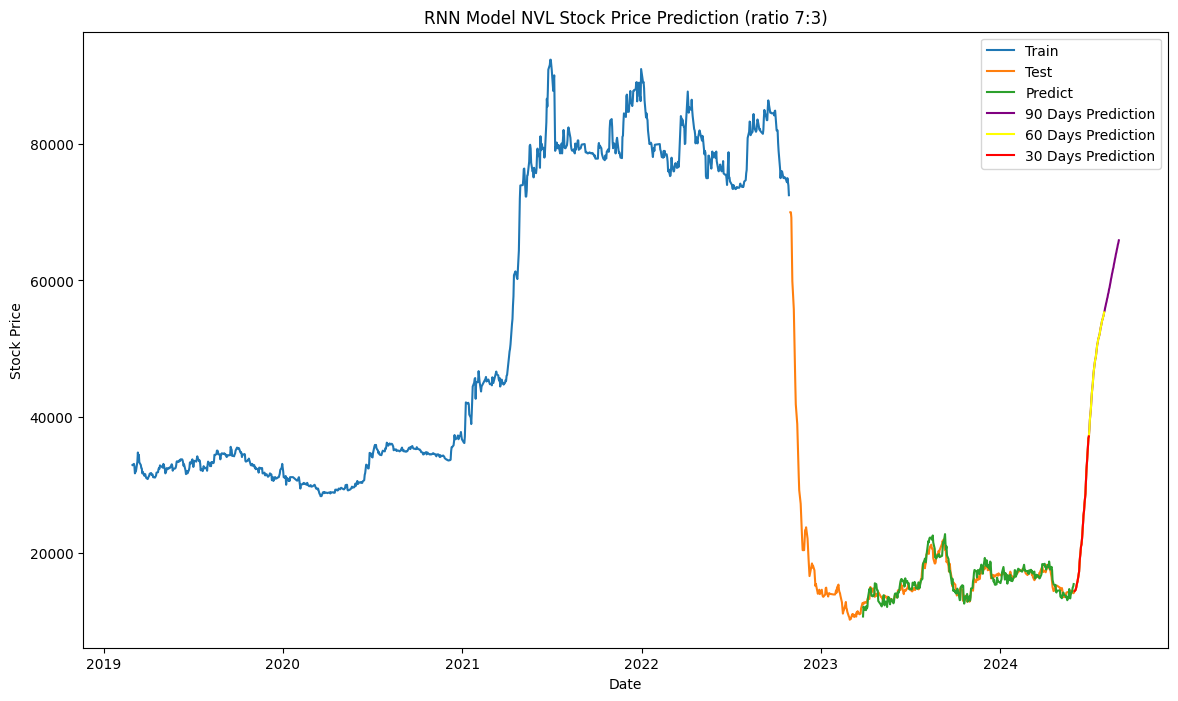

In [187]:
# 14. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=61)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=91)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('RNN Model NVL Stock Price Prediction (ratio 7:3)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

# 3. NLG Dataset

In [188]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [189]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('../Datasets/3 - NLG Historical Data.csv')
df = df.iloc[::-1].reset_index(drop=True)  # Reverse the dataframe
df['Date'] = pd.to_datetime(df['Date'])
df1 = df['Price'].str.replace(',', '').astype(float)

In [190]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [191]:
df1

array([[0.08706471],
       [0.09559049],
       [0.0913276 ],
       ...,
       [0.60812666],
       [0.59393056],
       [0.6000146 ]])

## Ratio 9:1

In [192]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [193]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [194]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [195]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [196]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [197]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0251 - val_loss: 0.0039
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.6646e-04 - val_loss: 0.0017
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.1398e-04 - val_loss: 0.0015
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.0197e-04 - val_loss: 0.0015
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.2350e-04 - val_loss: 0.0013
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/

In [198]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [199]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
ytest = scaler.inverse_transform(ytest.reshape(-1, 1))

In [200]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred) * 100
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 1156.7660945517673
Testing MAPE: 2.1251937471896807
Testing MAE: 857.7682711693549


In [201]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

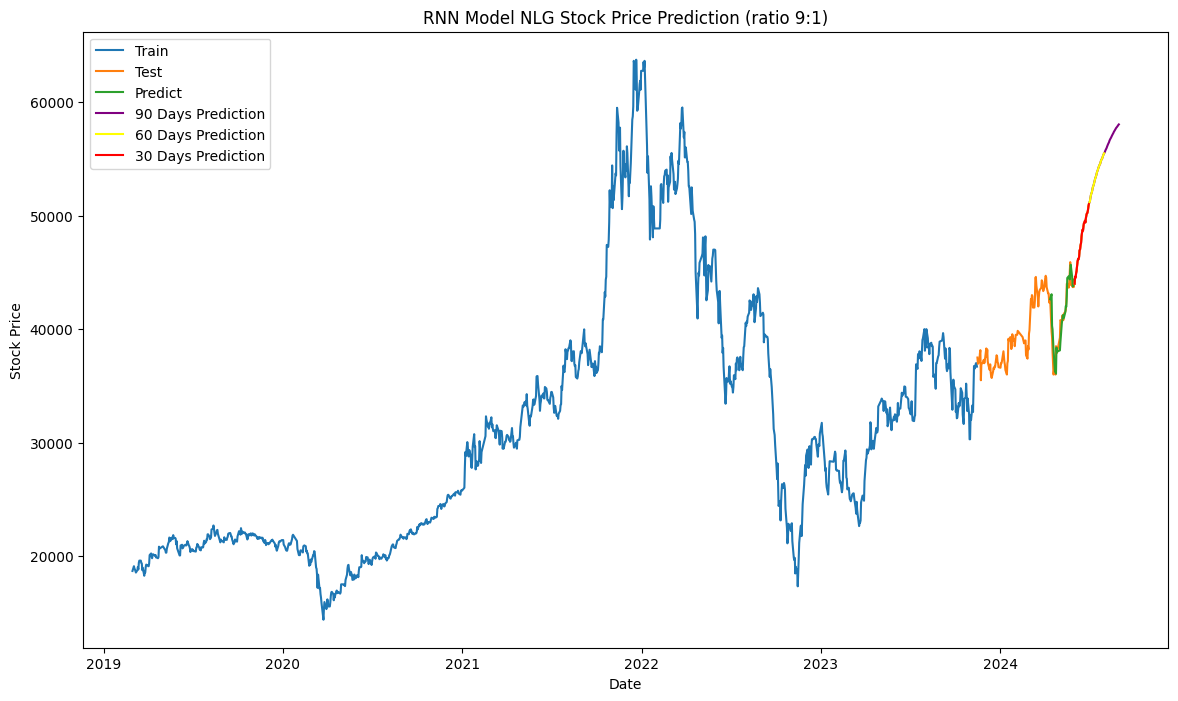

In [202]:
# 14. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=61)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=91)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('RNN Model NLG Stock Price Prediction (ratio 9:1)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

## Ratio 8:2

In [203]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [204]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [205]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [206]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [207]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [208]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0518 - val_loss: 0.0010
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0028 - val_loss: 0.0010
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0013 - val_loss: 9.2506e-04
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.4640e-04 - val_loss: 9.3300e-04
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0010 - val_loss: 8.9954e-04
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0012 - val_loss: 8.9921e-04
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.6196e-04 - val_loss: 7.7572e-04
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0011 - val_loss: 7.9910e-04
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.4464e-04 - val_loss: 7.3314e-04
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.9395e-04 - val_loss: 7.5910e-04
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.7226e-04 - val_loss: 7.3934e

In [209]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [210]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
ytest = scaler.inverse_transform(ytest.reshape(-1, 1))

In [211]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred) * 100
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 1027.1530844303325
Testing MAPE: 2.0232753287315592
Testing MAE: 763.3538652584876


In [212]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

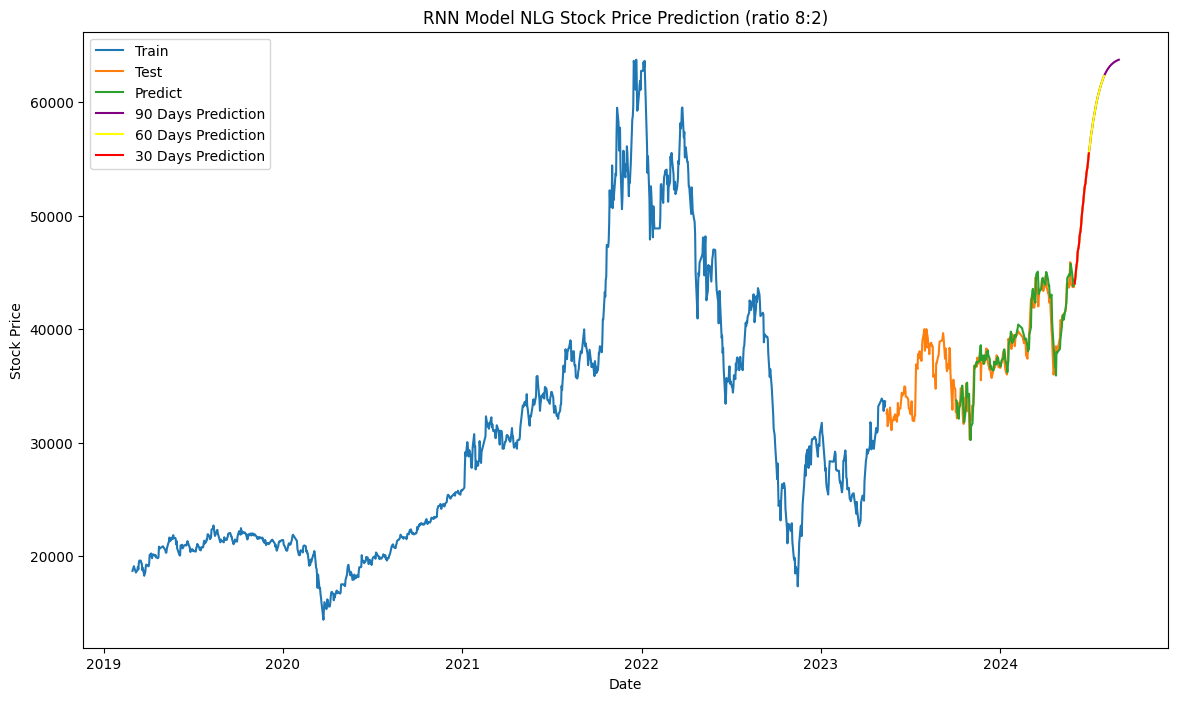

In [213]:
# 14. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=61)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=91)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('RNN Model NLG Stock Price Prediction (ratio 8:2)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

## Ratio 7:3

In [214]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [215]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [216]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [217]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [218]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [219]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.2609 - val_loss: 0.0111
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0115 - val_loss: 0.0042
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

In [220]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [221]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
ytest = scaler.inverse_transform(ytest.reshape(-1, 1))

In [222]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred) * 100
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 1263.0349319794716
Testing MAPE: 2.72956229095693
Testing MAE: 982.7799501386519


In [223]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

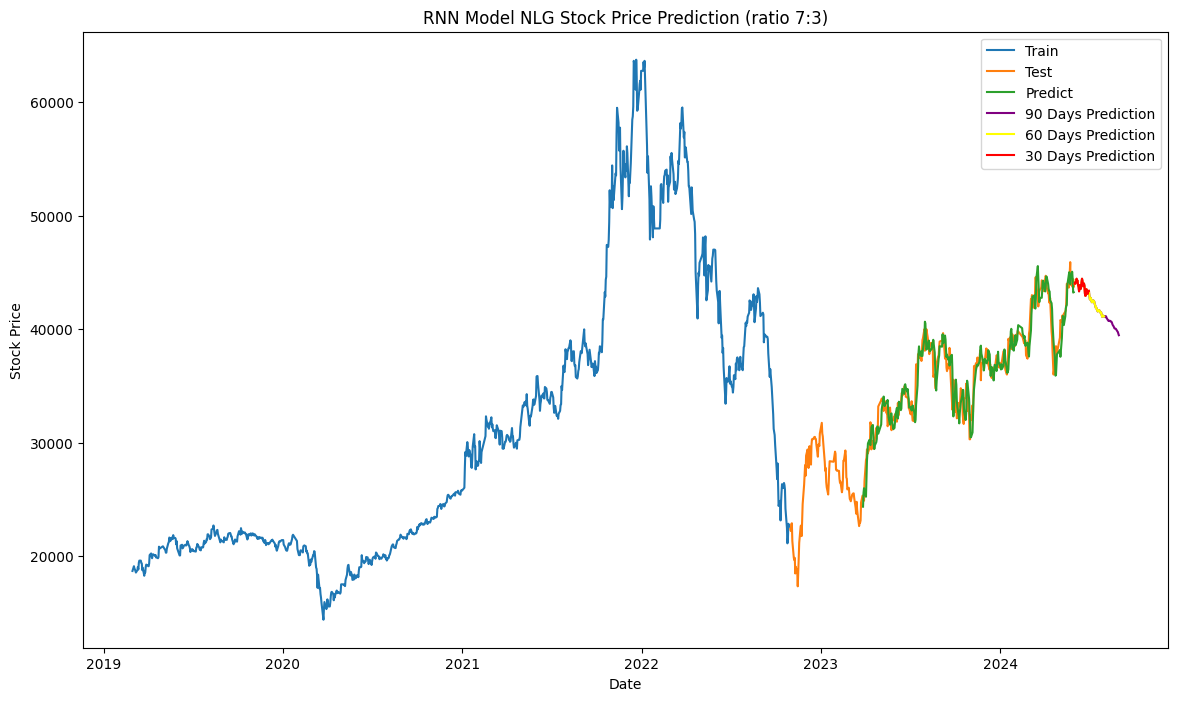

In [224]:
# 14. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_30_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_30_days), axis=0)
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=61)
future_60_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_60_days), axis=0)
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=91)
future_90_with_last = np.concatenate((scaler.inverse_transform(test_data[-1].reshape(-1, 1)), pred_90_days), axis=0)

# Vẽ 90 ngày
plt.plot(future_dates_90, future_90_with_last[:len(future_dates_90)], label='90 Days Prediction', color='purple')

# Vẽ 60 ngày
plt.plot(future_dates_60, future_60_with_last[:len(future_dates_60)], label='60 Days Prediction', color='yellow')

# Vẽ 30 ngày
plt.plot(future_dates_30, future_30_with_last[:len(future_dates_30)], label='30 Days Prediction', color='red')

plt.legend()
plt.title('RNN Model NLG Stock Price Prediction (ratio 7:3)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()